In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
file_nvidia_final_path = "Final_Nvidia_data.csv"
df_nvidia_final = pd.read_csv(file_nvidia_final_path)

In [3]:
# Chọn cột giá đóng cửa làm mục tiêu
target = "Close_x"
df_target = df_nvidia_final[target]

In [4]:
def generate_arima_predictions(series, total_length, order=(5,1,0)):
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=total_length)
    return forecast

# Tạo feature ARIMA cho toàn bộ dữ liệu
arima_forecast = generate_arima_predictions(df_target, len(df_target))

In [5]:
# Các feature đầu vào
features = ["High", "Low", "Open", "Volume", "DPRIME", "Inflation(%)", "Close_fpt", "Bitcoin_Price(USD)"]

# Chuẩn hóa
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_nvidia_final[features + [target]])

# Thêm feature ARIMA (reshape về cột dọc)
arima_feature = np.array(arima_forecast).reshape(-1, 1)

# Kết hợp vào dữ liệu đã chuẩn hóa
final_data = np.concatenate((scaled_data, arima_feature), axis=1)

In [6]:
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i: (i + time_steps), :])  # Lấy tất cả các cột (bao gồm ARIMA feature)
        y.append(data[i + time_steps, -2])      # target là cột "Close_x", vị trí -2 (trước ARIMA)
    return np.array(X), np.array(y)

# Chia lại dữ liệu train-test
train_size = int(len(final_data) * 0.8)
train_data, test_data = final_data[:train_size], final_data[train_size:]

# Tạo X, y cho LSTM
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (2926, 30, 10) (2926,)
Test shape: (710, 30, 10) (710,)


In [ ]:
# # Chia dữ liệu thành tập huấn luyện và kiểm tra (80-20%)
# train_scaled = df_scaled[:train_size]
# test_scaled = df_scaled[train_size:]

In [7]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\ngodinhanhquoc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,689 (479.25 KB)

 Trainable params: 122,689 (479.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Huấn luyện
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Đánh giá
loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.3421e-05 - val_loss: 0.1294
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.9882e-05 - val_loss: 0.1270
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.1045e-05 - val_loss: 0.1307
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.7866e-05 - val_loss: 0.1258
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.9844e-05 - val_loss: 0.1308
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.0918e-05 - val_loss: 0.1262
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.5320e-05 - val_loss: 0.1327
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.8652e-05 - val_loss: 0.1245
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.4937e-05 - val_loss: 0.1300
Epoch 10/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.7801e-05 - val_loss: 0.1352
Epoch 11/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.6951e-05 - val_loss: 0.1295
Epoch 12/50
92/92 ━

In [22]:
print(model.input_shape)

(None, 30, 10)


In [23]:
model.save("model_ARIMA.keras")  # Format chuẩn mới của Keras

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE: 0.38296801836480243, MAE: 0.29033736387173703


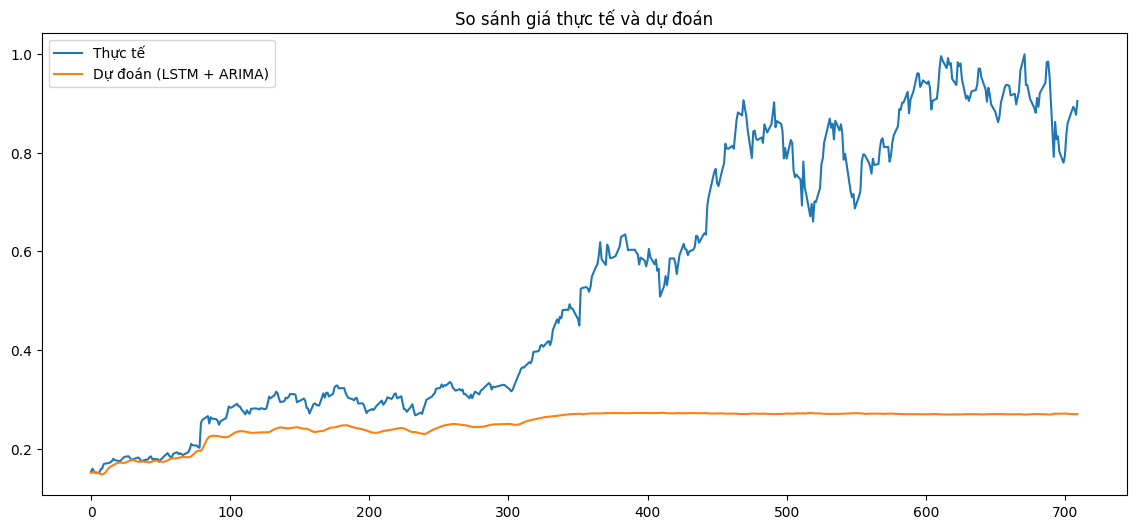

In [24]:
# Dự đoán
y_pred = model.predict(X_test)

# Đánh giá
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}")

# Vẽ biểu đồ so sánh
plt.figure(figsize=(14,6))
plt.plot(y_test, label='Thực tế')
plt.plot(y_pred, label='Dự đoán (LSTM + ARIMA)')
plt.legend()
plt.title('So sánh giá thực tế và dự đoán')
plt.show()

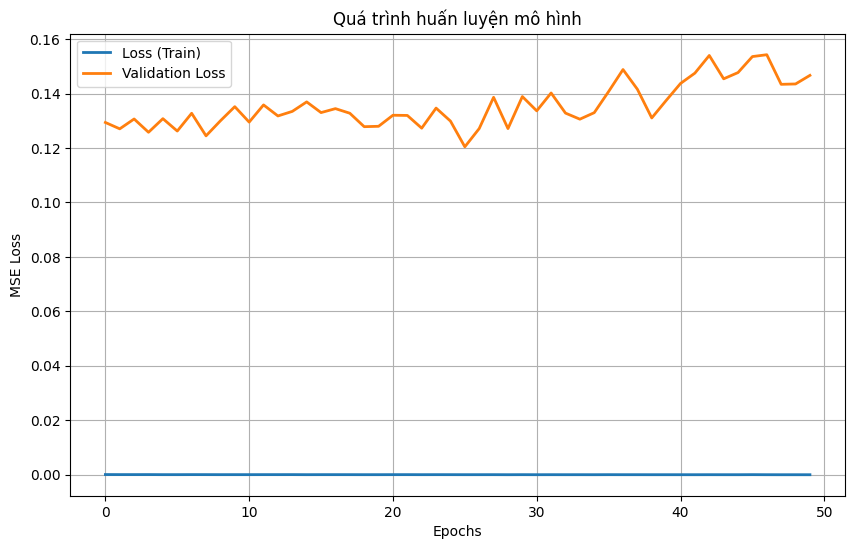

In [25]:
# Trực quan hóa quá trình huấn luyện
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Loss (Train)', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Quá trình huấn luyện mô hình')
    plt.legend()
    plt.grid(True)
    plt.show()

# Gọi hàm sau khi huấn luyện
plot_training_history(history)


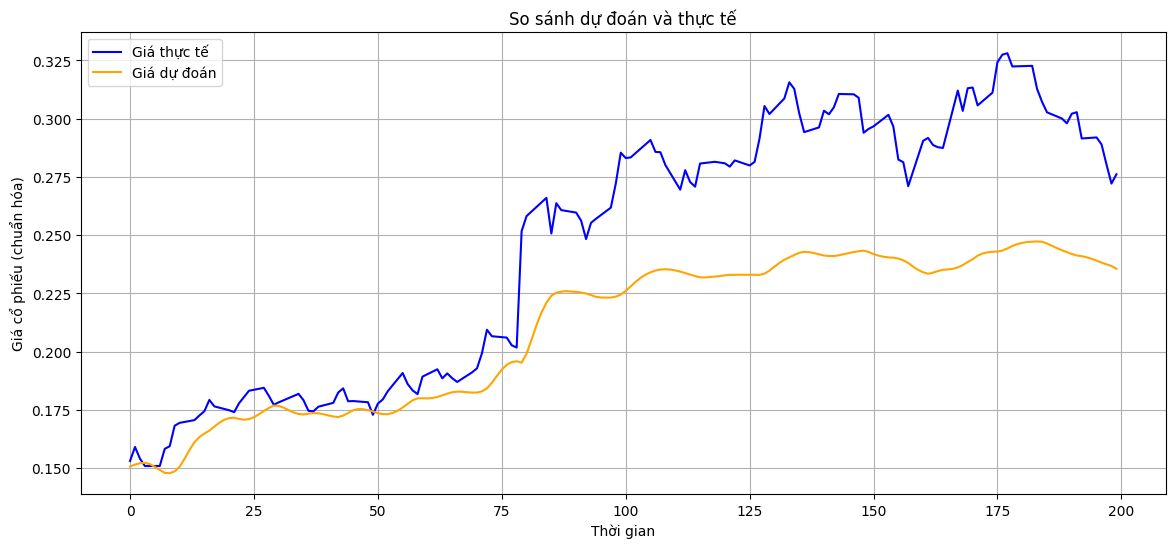

In [26]:
# So sánh chi tiết hơn giá thực tế và dự đoán (biểu đồ zoom chi tiết)
def plot_predictions(y_true, y_pred, title="So sánh dự đoán và thực tế", start=0, end=200):
    plt.figure(figsize=(14, 6))
    plt.plot(y_true[start:end], label='Giá thực tế', color='blue')
    plt.plot(y_pred[start:end], label='Giá dự đoán', color='orange')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá cổ phiếu (chuẩn hóa)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Gọi hàm
plot_predictions(y_test, y_pred, start=0, end=200)  # Hiển thị 200 điểm đầu tiên để dễ nhìn

In [29]:
print("X_test shape:", X_test.shape)
print("X_test sample:", X_test[:5])  # In 5 dòng đầu


X_test shape: (710, 30, 10)
X_test sample: [[[1.38505932e-01 1.37870251e-01 1.33658577e-01 ... 2.15184734e-01
   1.38402827e-01 1.35476557e+02]
  [1.38124094e-01 1.37863464e-01 1.33235020e-01 ... 2.13428404e-01
   1.38378228e-01 1.35476557e+02]
  [1.42634061e-01 1.40331722e-01 1.37007686e-01 ... 2.18225023e-01
   1.45649540e-01 1.35476557e+02]
  ...
  [1.54134777e-01 1.54564875e-01 1.50947770e-01 ... 2.09593786e-01
   1.56415647e-01 1.35476557e+02]
  [1.54894073e-01 1.55371805e-01 1.52194410e-01 ... 2.10389058e-01
   1.55664371e-01 1.35476557e+02]
  [1.55653368e-01 1.56178735e-01 1.53441051e-01 ... 2.10293150e-01
   1.54913094e-01 1.35476557e+02]]

 [[1.38124094e-01 1.37863464e-01 1.33235020e-01 ... 2.13428404e-01
   1.38378228e-01 1.35476557e+02]
  [1.42634061e-01 1.40331722e-01 1.37007686e-01 ... 2.18225023e-01
   1.45649540e-01 1.35476557e+02]
  [1.46685835e-01 1.46149766e-01 1.43590208e-01 ... 2.15518102e-01
   1.45864204e-01 1.35476557e+02]
  ...
  [1.54894073e-01 1.55371805e-01 1